In [1]:
import ast
import os
import math
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter

df = pd.read_csv('../data/compound/CF_sim_IME_only_exploded/results_long.csv')

In [2]:
df = df[df['scheme']!='baseline_fixed']
df['scheme'] = df['scheme'].replace('vary_imp', 'Vary MI')
df['scheme'] = df['scheme'].replace('vary_model', 'Vary Model')
df['scheme'] = df['scheme'].replace('vary_eval', 'Vary Eval')
df['scheme'] = df['scheme'].replace('vary_all', 'Vary All')


/tmp/ipykernel_1570733/1915895544.py:105: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  bp = ax1.bxp(


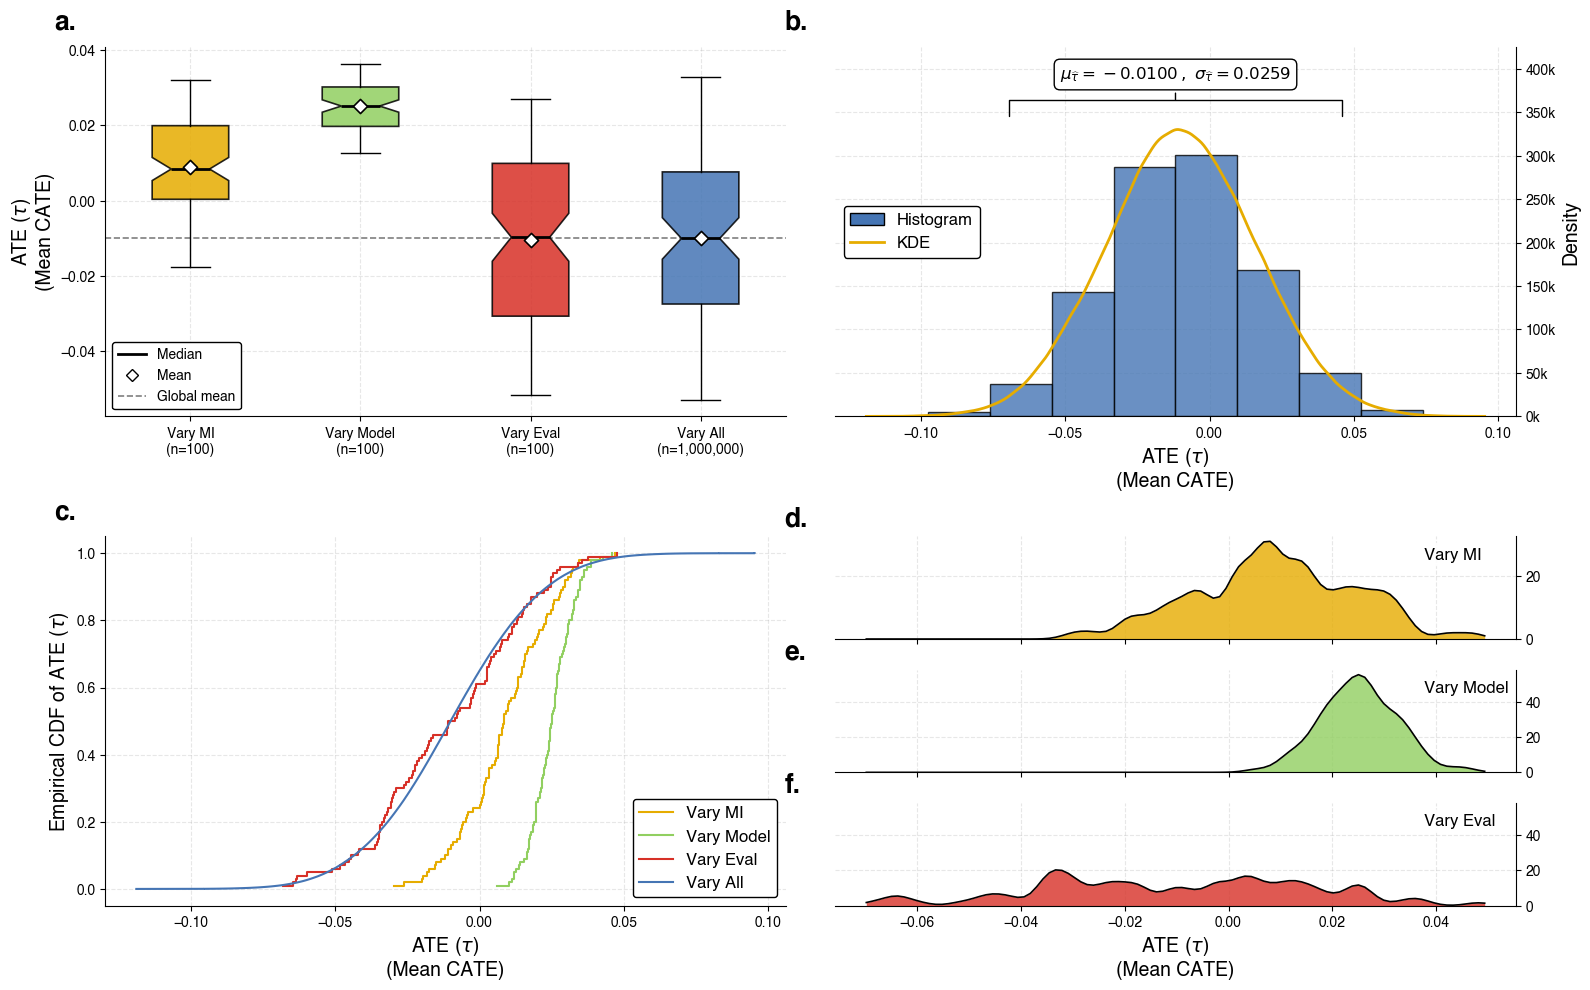

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns3
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Helvetica'
figure_path = os.path.join(os.getcwd(), '..', 'figures')

# Ensure grids/ticks render beneath all plotted artists globally
plt.rcParams['axes.axisbelow'] = True

# Palette: blue reserved for 'Vary All'
colors = [
    '#4575b4',  # blue (from Spectral)
    '#E6AC00',  # gold (custom)
    '#91cf60',  # green (from Spectral)
    '#d73027',  # red (from Spectral)
]

color_map = {
    'Vary All':   colors[0],
    'Vary MI':    colors[1],
    'Vary Model': colors[2],
    'Vary Eval':  colors[3],
}
# Desired global ordering
desired_order = ['Vary MI', 'Vary Model', 'Vary Eval', 'Vary All']

# -------- helper: simple Gaussian smoothing on a histogram-based density --------
def smoothed_density(x, bins, smooth_bins=2):
    """
    Compute a smoothed density from samples x using an equally spaced histogram
    and a discrete Gaussian kernel of width 'smooth_bins' (in bin units).
    """
    counts, edges = np.histogram(x, bins=bins, density=True)
    centers = 0.5 * (edges[1:] + edges[:-1])
    if smooth_bins <= 0:
        return centers, counts
    radius = max(3 * smooth_bins, 1)
    kx = np.arange(-radius, radius + 1, dtype=float)
    kernel = np.exp(-0.5 * (kx / smooth_bins) ** 2)
    kernel /= kernel.sum()
    density_smooth = np.convolve(counts, kernel, mode="same")
    return centers, density_smooth

# -------- helper: stats for bxp with a common effective n for notch width -----
def bxp_stats(groups, labels, eff_n=None, whis=(5, 95)):
    stats = []
    if eff_n is None:
        eff_n = min(len(np.asarray(g)[~np.isnan(g)]) for g in groups if len(g))
    for lab, g in zip(labels, groups):
        x = np.asarray(g, float)
        x = x[~np.isnan(x)]
        if x.size == 0:
            continue
        q1, q3 = np.percentile(x, [25, 75])
        med = np.median(x)
        whislo, whishi = np.percentile(x, whis)
        iqr = q3 - q1
        half = 1.57 * iqr / np.sqrt(eff_n)  # common effective n for visible notch
        stats.append(dict(
            label=f"{lab}\n(n={x.size:,})",
            q1=q1, q3=q3, med=med, whislo=whislo, whishi=whishi,
            cilo=med - half, cihi=med + half, fliers=[]
        ))
    return stats

# ------------------- Figure & layout -------------------
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(2, 2, figure=fig)

# First row
ax1 = fig.add_subplot(gs[0, 0])  # boxplots
ax2 = fig.add_subplot(gs[0, 1])  # histogram + KDE

# Second row: **swap** so ax4 is LEFT and ridge stack is RIGHT
ax4 = fig.add_subplot(gs[1, 0])  # ECDFs on the left now
gs_right = gs[1, 1].subgridspec(3, 1, hspace=0.3)
ax3a = fig.add_subplot(gs_right[0, 0])
ax3b = fig.add_subplot(gs_right[1, 0], sharex=ax3a)
ax3c = fig.add_subplot(gs_right[2, 0], sharex=ax3a, sharey=ax3b)

# --- grids beneath plots (low zorder) ---
grid_kws = dict(which="both", linestyle='--', alpha=0.3, zorder=0)
for ax in (ax1, ax2, ax3a, ax3b, ax3c, ax4):
    ax.set_axisbelow(True)
    ax.grid(**grid_kws)

# ------------------- Order data consistently -------------------
unique_schemes = df["scheme"].unique().tolist()
schemes_order = [s for s in desired_order if s in unique_schemes]
data = [df.loc[df["scheme"] == s, "ate_hat"].values for s in schemes_order]

# --- polished boxplot on ax1 (NO jitters), with visible notches via bxp ------
groups  = [np.asarray(a, float) for a in data]
palette = [color_map[s] for s in schemes_order]
Ns      = [np.sum(~np.isnan(g)) for g in groups]
overall_mean = (float(np.nanmean(np.concatenate(groups)))
                if any(len(g) for g in groups) else np.nan)

stats = bxp_stats(groups, schemes_order, eff_n=min(n for n in Ns if n > 0), whis=(5, 95))
bp = ax1.bxp(
    stats, showfliers=False, shownotches=True, patch_artist=True, zorder=2.0,
    boxprops=dict(linewidth=1.2, color="k"),
    medianprops=dict(linewidth=2.0, color="k"),
    whiskerprops=dict(linewidth=1.0, color="k"),
    capprops=dict(linewidth=1.0, color="k"),
)
for box, c in zip(bp["boxes"], palette):
    box.set(facecolor=c, alpha=0.85, edgecolor="k")

# mean diamonds (white fill, black edge) per group
means = [float(np.nanmean(g)) if np.sum(~np.isnan(g)) else np.nan for g in groups]
ax1.scatter(
    np.arange(1, len(means) + 1), means,
    marker="D", s=52, facecolor="white", edgecolor="k", linewidth=1.2,
    zorder=3.0, label="Mean"
)

# global mean reference line (dashed)
if not np.isnan(overall_mean):
    ax1.axhline(overall_mean, linestyle="--", linewidth=1.2,
                color="k", alpha=0.5, zorder=1.5)

# legend
legend_handles = [
    Line2D([0], [0], color="k", lw=2, label="Median"),
    Line2D([0], [0], marker="D", markersize=6, markerfacecolor="white",
           markeredgecolor="k", lw=0, label="Mean"),
    Line2D([0], [0], color="k", lw=1.2, linestyle="--", alpha=0.5,
           label="Global mean"),
]
ax1.legend(handles=legend_handles, loc="lower left",
           frameon=True, facecolor="w", edgecolor=(0,0,0,1), framealpha=1)

# ------------------- ECDFs on ax4 (left), fixed order & colors ----------------
for s in schemes_order:  # Vary MI, Vary Model, Vary Eval, Vary All
    g = df.loc[df["scheme"] == s, "ate_hat"].values
    if g.size == 0:
        continue
    x = np.sort(g)
    y = np.arange(1, x.size + 1) / x.size
    ax4.step(x, y, where="post", label=s, color=color_map[s], zorder=2.5)
ax4.legend(loc="lower right", frameon=True,
           fontsize=12, framealpha=1, facecolor='w',
           edgecolor=(0, 0, 0, 1))

# --- histogram (counts) + KDE overlay on the same scale (ax2) ---
vals = df.loc[df['scheme'] == 'Vary All', 'ate_hat'].to_numpy()
n_counts, edges, _ = ax2.hist(
    vals, edgecolor='k', color=color_map['Vary All'], alpha=0.8, zorder=2.0
)
xgrid = np.linspace(edges[0], edges[-1], 512)
try:
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(vals)      # Scott’s rule by default
    dens = kde(xgrid)
except Exception:
    centers, dens_centers = smoothed_density(vals, bins=edges, smooth_bins=2)
    dens = np.interp(xgrid, centers, dens_centers, left=0.0, right=0.0)
bin_width = np.diff(edges).mean()
kde_counts = dens * vals.size * bin_width
ax2.plot(xgrid, kde_counts, linewidth=2.0, color=colors[1], zorder=3.0, label='KDE')

# ------------------- Ridge plot across ax3a/3b/3c (right) --------------------
ridge_specs = [
    ("Vary MI",    ax3a),
    ("Vary Model", ax3b),
    ("Vary Eval",  ax3c),
]
present = [len(df.loc[df["scheme"] == name, "ate_hat"].values) > 0 for name, _ in ridge_specs]
all_x = (np.concatenate([
    df.loc[df["scheme"] == name, "ate_hat"].values
    for (name, _), ok in zip(ridge_specs, present) if ok
]) if any(present) else np.array([]))
if all_x.size > 0:
    x_min, x_max = np.min(all_x), np.max(all_x)
    pad = 0.02 * (x_max - x_min if x_max > x_min else 1.0)
    bins = np.linspace(x_min - pad, x_max + pad, 100)
    for name, ax in ridge_specs:
        x = df.loc[df["scheme"] == name, "ate_hat"].values
        if x.size == 0:
            ax.set_visible(False)
            continue
        centers, dens = smoothed_density(x, bins=bins, smooth_bins=2)
        ax.fill_between(centers, dens, 0.0, alpha=0.8, linewidth=0,
                        color=color_map[name], zorder=2.0)
        ax.plot(centers, dens, linewidth=1.2, color='k', zorder=3.0)
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(0, ymax)
    for _ax in (ax3a, ax3b):
        _ax.tick_params(axis="x", which="both", labelbottom=False)


# Panel titles (reflect swap: ECDFs bottom-left; ridges on right)
ax1.set_title('a.', loc='left', fontsize=19, y=1.025, x=-0.075, fontweight='bold')
ax2.set_title('b.', loc='left', fontsize=19, y=1.025, x=-0.075, fontweight='bold')
ax3a.set_title('d.', loc='left', fontsize=19, y=1.025, x=-0.075, fontweight='bold')
ax3b.set_title('e.', loc='left', fontsize=19, y=1.025, x=-0.075, fontweight='bold')
ax3c.set_title('f.', loc='left', fontsize=19, y=1.025, x=-0.075, fontweight='bold')
ax4.set_title('c.', loc='left', fontsize=19, y=1.025, x=-0.075, fontweight='bold')

# Despine
sns.despine(ax=ax1); sns.despine(ax=ax2); sns.despine(ax=ax4)

# Annotation on ax2 (mean & SD; unbiased ddof=1)
def annotator(input_list, ax):
    x = np.asarray(input_list, float)
    x = x[~np.isnan(x)]
    mean = float(np.nanmean(x)) if x.size else np.nan
    sd   = float(np.nanstd(x, ddof=1)) if x.size > 1 else np.nan
    text = rf"$\mu_{{\widehat{{\tau}}}}={mean:.4f}\,,\ \sigma_{{\widehat{{\tau}}}}={sd:.4f}$"
    ax.annotate(text, xy=(0.5, 0.85), xytext=(0.5, 0.90), xycoords="axes fraction",
                fontsize=12, ha="center", va="bottom",
                bbox=dict(boxstyle="round,pad=0.35", fc="white"),
                arrowprops=dict(arrowstyle='-[, widthB=10.0, lengthB=1', lw=1.0))

annotator(df.loc[df['scheme'] == 'Vary All', 'ate_hat'], ax2)
ax2.set_ylim(0, 425000)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y/1000:.0f}k"))

legend_elements2 = [
    Patch(facecolor=color_map['Vary All'], edgecolor=(0, 0, 0, 1), label='Histogram'),
    Line2D([0], [0], color=colors[1], lw=2, linestyle='-', label='KDE', alpha=1),
]
ax2.legend(handles=legend_elements2, loc='center left', frameon=True,
           fontsize=12, framealpha=1, facecolor='w',
           edgecolor=(0, 0, 0, 1)
           , ncols=1)

ax1.set_ylabel(r'ATE ($\tau$)'+'\n(Mean CATE)', fontsize=14)
ax2.set_xlabel(r'ATE ($\tau$)'+'\n(Mean CATE)', fontsize=14)
ax2.set_ylabel(r'Density', fontsize=14)
ax3c.set_xlabel(r'ATE ($\tau$)' + '\n(Mean CATE)', fontsize=14)
ax4.set_ylabel(r'Empirical CDF of ATE ($\tau$)', fontsize=14)
ax4.set_xlabel(r'ATE ($\tau$)' + '\n(Mean CATE)', fontsize=14)

ax3a.text(0.865, 0.75, 'Vary MI', transform=ax3a.transAxes, ha='left', va='bottom',
          fontsize=12, bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='none', alpha=0.9))

ax3b.text(0.865, 0.75, 'Vary Model', transform=ax3b.transAxes, ha='left', va='bottom',
          fontsize=12, bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='none', alpha=0.9))

ax3c.text(0.865, 0.75, 'Vary Eval', transform=ax3c.transAxes, ha='left', va='bottom',
          fontsize=12, bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='none', alpha=0.9))

sns.despine(ax=ax2, left=True, right=False)
sns.despine(ax=ax3a, left=True, right=False)
sns.despine(ax=ax3b, left=True, right=False)
sns.despine(ax=ax3c, left=True, right=False)

for _ax in (ax2, ax3a, ax3b, ax3c):
    _ax.yaxis.set_label_position("right")
    _ax.yaxis.tick_right()
    _ax.tick_params(axis="y", which="both",
                    right=True, labelright=True,
                    left=False, labelleft=False)

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'compound_simulation.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figure_path, 'compound_simulation.png'), bbox_inches='tight', dpi=600)
plt.savefig(os.path.join(figure_path, 'compound_simulation.svg'), bbox_inches='tight')